# Loss computation in PYLEECAN

## Iron losses

### Theory

Iron losses are computed thanks to a Steinmetz equation. It takes into account the contribution of hysteresis and Eddy current losses. The coefficients of the equation must be fitted to experimental loss data for each material.
$$
	P = k_{hy} f^{\alpha_f} B^{\alpha_B} + k_{ed} f^2 B^2 
$$


+ $P$ is the loss density,
+ $k_{hy}$ and $k_{ed}$ are coefficients found by curve-fitting,
+ $f$ is the frequency of the magnetic fluc density,
+ $B$ is the amplitude of the magnetic flux density.

Several equations exist to compute iron losses. The one presented above seems to give the better correlation with the input data. For example, another well known formula is the Bertotti's one:

$$
  P = k_{hy} f B + k_{ed} f^2 B^2 + k_{ex} f^{1.5} B^{1.5}
$$

The two models have been implemented in PYLEECAN and it is possible to compare them.

### Implementation in PYLEECAN

The Steinmetz equation enables to compute the loss density in each element of the mesh, thanks to the value of the magnetic flux density $B$ given by the FEMM simulation.

The curve-fitting allowing to compute the coefficients have been implemented in PYLEECAN. The loss data of the material can be stored in an ImportMatrix in the material.

It is necessary to take into account the harmonics of $B$. Indeed, the Steinmetz equation enables to compute the losses when $B$ is sinusoidal. Thus, the Fourier transform of the magnetic flux density is used and the loss is the sum of the contribution of each harmonic:

$$
  P = \sum_{\nu = 0}^{N} \left( k_{hy} f_{\nu}^{\alpha_f} B_{\nu}^{\alpha_B} + k_{ed} f_{\nu}^2 B_{\nu}^2 \right)
$$
with $N$ the number of harmonics taken into account.

In this equation, the coefficients $k_{hy}$ and $k_{ed}$ found by curve-fitting are divided by the stacking factor of the lamination. 

## Magnet loss

The magnet losses are computed according to the method described in:
 D. Ishak, Z. Q. Zhu, et D. Howe, « Eddy-current loss in the rotor magnets of permanent-magnet brushless machines having a fractional number of slots per pole », IEEE Transactions on Magnetics, vol. 41, nᵒ 9, p. 2462‑2469, sept. 2005, doi: 10.1109/TMAG.2005.854337.
This method uses the current density $J$ in the magnets. This current density is calculated from the vector magnetic potential $A$ according to the following equation:
$$
  J_m = - \sigma_m \frac{\partial A}{\partial t} + J_c
$$


+ $\sigma_m$ is the magnet conductivity,
+ $J_c$ is an integration constant which imposes that the total current density in the magnet is null.

The current density in the magnets enables to compute the loss density in each element of the mesh according to the equation:

$$
  P = \frac{1}{2 \sigma_m} k_{seg} J_{mfft}^2
$$

with :
$$
  J_{mfft} = - j \sigma_m \omega (A_{zfft} - A_{zmean})
$$
The term $A_{zmean}$ correspond to the integration constant $J_c$.

$k_{seg}$ is a coefficient that allows to take magnet segmentation into account. Segmentation means that the magnets are divided in several blocks in the axial direction of the electrical machine. $k_{seg}$ is given by the following equation:

$$
  k_{seg} = {\left(\frac{L_{mag} + W_{mag}}{L_{mag} N_{seg} + W_{mag}}\right)}^2 
$$

with :

+ $L_{mag}$ the length of the magnets
+ $W_{mag}$ the width of the magnets
+ $N_{seg}$ the number of segments that consitute the magnets



## Skin effect
	
It is necessary to take skin effect into account to compute Joule losses. To achieve this, a coefficient that decreases the material conductivity is computed with respect to the electrical frequency. The following equation from J. Pyrhonen, T. Jokinen, et V. Hrabovcova, Design of Rotating Electrical Machines. John Wiley & Sons, 2013, enables to compute this coefficient:

$$
  \begin{cases}
    k_{skin} = 1 + 0.59 \times \frac{zt^2 - 0.2}{9} \times \xi^4 \quad \textrm{for circular conductors}\\
    k_{skin} = 1 + \frac{zt^2 - 0.2}{9} \times \xi^4 \quad \textrm{for rectangular conductors}
  \end{cases}
$$

with :

$$
  \xi = h_c  \sqrt{\frac{1}{2}  \omega  \mu_0  \mu_r  \sigma  z_a  \frac{bc_0}{b}}
$$

  + $h_c = z_p \times h_{c0}$
    - $z_p$ the number of adjacent wires in the radial direction,
    - $h_{c0}$ the height of the wires

  + $b_{c0}$ the width of the wires
  + $z_a$ the number of adjacent wires in the tangential directon

## Proximity effect losses

Proximity effect losses are caused by induced currents in the windings. Each conductor creates a magnetic field that induce curent in adjacent conductors. This is called proximity effect. To be computed precisely, it would require a fine modelling of each conductor in the slots. That is not the case in PYLEECAN. In the software, the whole slot is considered as a uniform soucre of current on all the active surface. Thus, the proximity effect loss is computed according to an approximation that takes the global magnetic flux density in the slots. The computation is done in the same way as eddy current losses in the iron. It uses the frequency and the amplitude of the flux density:

$$
  P = k_p f^2 B^2 
$$

with :

$$
  k_p = k_{sfill}\frac{\pi^2}{8} \sigma_{wire} d_{wire}^2 
$$

where :

+ $k_{sfill}$ is the filling factor of the slots
+ $\sigma_{wire}$ is the electrical conductivity of the conductors
+ $d_{wire}$ the diameter of the wires


### Version information

In [10]:
import sys
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\LAP10\Documents\Loss\pyleecan")
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print(f'Pyleecan version : {pyleecan.__version__}')
import SciDataTool
print(f'SciDataTool version : {SciDataTool.__version__}')

Running date: August 26, 2022
Pyleecan version : 1.4.0
SciDataTool version : 2.4.8


# Validation case

The machine used for the validation of the loss models is taken from the FEMM website D. Meeker, « Rotating Losses in a Surface Mount Permanent Magnet Motor:Finite Element Method Magnetics ». https://www.femm.info/wiki/SPMLoss. It is a 60W surface permanent magnet synchronous machine (SPMSM) with 8 pole pairs and 18 stator slots. The machine is imported and plotted below.


In [11]:
# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

machine = load(join(DATA_DIR, "Machine", "SPMSM_18s16p_loss.json"))
machine.plot()

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'SPMSM_18s16p_loss'}, xlabel='Position along x-axis [m]', ylabel='Position along y-axis [m]'>)

The FEMM website provides two figures that can be reproduced in PYLEECAN.

![](./Images/loss_mesh_meeker.PNG)
![](./Images/loss_vs_speed_meeker.PNG)

To reproduce these figures, a simulation with the magnetic and loss module will be carried out. The definition of the magnetic part of the simulation is similar to the tutorial "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)"

In [13]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.LossFEMM import LossFEMM
from pyleecan.Classes.LossModelSteinmetz import LossModelSteinmetz
from pyleecan.Classes.LossModelBertotti import LossModelBertotti
from pyleecan.Classes.LossModelWinding import LossModelWinding
from pyleecan.Classes.LossModelProximity import LossModelProximity
from pyleecan.Classes.LossModelMagnet import LossModelMagnet
from pyleecan.Classes.OutLoss import OutLoss
import numpy as np

simu = Simu1(name="test_FEMM_Loss_SPMSM", machine=machine)

simu.input = InputCurrent(
    Nt_tot=16 * 20,
    Na_tot=1000 * 2,
    OP=OPdq(N0=4000, Id_ref=0, Iq_ref=np.sqrt(2)),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,  # Use spatioal periodicity in FEMM
    is_periodicity_t=True,
    nb_worker=4,  # Parallelization 
    is_get_meshsolution=True,  # Needed to compute losses
    FEMM_dict_enforced={  # Enforced mesh param to speed-up computation
        "mesh": {
            "meshsize_airgap": 0.00014,
            "elementsize_airgap": 0.00014,
            "smart_mesh": 0,
        },
    },
    is_periodicity_rotor=True,
    is_calc_torque_energy=False,  # Skip torque computation
)

Now, a loss module is defined to compute the losses in post-processing of the magnetic simulation.

The reference website gives the values of the loss coefficients used for iron losses and proximity losses. These coefficients will be used, but thay can also be computed is they are None.

In [12]:
Ch = 0.00844 / 0.453592
Ce = 31.2e-6 / 0.453592
Cprox = 4.1018  # sigma_w * cond.Hwire * cond.Wwire

In [14]:
simu.loss = LossFEMM(
    k_ed = Ce,  # eddy current loss coefficients [W/(m3*T2*Hz2)]
    k_hy = Ch,  # hysteresis loss coefficients [W/(m3*T2*Hz)]
    k_p=Cprox,  # proximity loss coefficients [W/(m3*T2*Hz2)]
    is_get_meshsolution=True,  # For post-processing
    Tsta=120,  # Stator temperature [degC] 
    type_skin_effect = 0  # Skin effect for resistance calculation for Joule Model (0 to ignore skin effect, 1 to consider it)
)

Once the simulation is carried out, it is possible to print the values of the losses.

In [15]:
out = simu.run()

power_dict = {
    "total_power": out.mag.Pem_av,
    **dict([(o.name,o.get_loss_scalar(out.elec.OP.felec)) for o in out.loss.loss_list])
}
print(power_dict)

[16:02:09] Starting running simulation test_FEMM_Loss_SPMSM (machine=SPMSM_18s16p_loss)
[16:02:09] Starting Magnetic module
[16:02:15] Solving time steps: 0%
[16:02:15] Solving time steps: 0%
[16:02:15] Solving time steps: 0%
[16:02:16] Solving time steps: 0%
[16:02:58] Solving time steps: 25%
[16:02:58] Solving time steps: 25%
[16:02:58] Solving time steps: 25%
[16:02:58] Solving time steps: 25%
[16:03:36] Solving time steps: 50%
[16:03:36] Solving time steps: 50%
[16:03:36] Solving time steps: 50%
[16:03:36] Solving time steps: 50%
[16:04:16] Solving time steps: 75%
[16:04:16] Solving time steps: 75%
[16:04:16] Solving time steps: 75%
[16:04:16] Solving time steps: 75%
[16:04:52] Solving time step: 100%
[16:04:52] Solving time step: 100%
[16:04:52] Solving time step: 100%
[16:04:52] Solving time step: 100%
[16:04:52] Running LossFEMM module
[16:04:55] End of simulation test_FEMM_Loss_SPMSM
{'total_power': 61.87840438703773, 'stator core': 3.3258382558646318, 'rotor core': 0.044037039

Then, it is possible to reproduce the figure showing the loss value versus speed.

In [16]:
from SciDataTool.Functions.Plot.plot_2D import plot_2D
import numpy as np
speed_array = np.linspace(10, 8000, 100)
p = machine.get_pole_pair_number()

array_list = [np.array([o.get_loss_scalar(speed / 60 *p) for speed in speed_array])
                for o in out.loss.loss_list]

plot_2D(
    [speed_array],
    array_list,
    xlabel="Speed [rpm]",
    ylabel="Losses [W]",
    legend_list=[o.name for o in out.loss.loss_list],
)

The loss meshsolution can also be shown to see where the losses are located in the machine.

In [17]:
group_names = [
"stator core",
"rotor core",
"rotor magnets"
]
for loss in out.loss.loss_list:
    if "joule" in loss.name or "proximity" in loss.name :
        group_names.append("stator winding")
        loss.get_mesh_solution().plot_contour(
        "freqs=sum",
        label=f"{loss.name} loss density (W/m^3)",
        group_names = group_names
        )
        group_names.pop()
    else:
        loss.get_mesh_solution().plot_contour(
        "freqs=sum",
        label=f"{loss.name} loss density (W/m^3)",
        group_names = group_names
        )

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

### Loss calculation example for the Toyota Prius electrical machine

The machine used in this tutorial will be the Toyota Prius machine.

In [18]:
# Load the machine

machine = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

## First loss Simulation

A first loss simulation on one operating point will be carried out in this section.

### Definition of the simulation

A simulation is defined using the Pyleecan objects.

In [19]:

%matplotlib inline
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.Loss import Loss
from pyleecan.Classes.LossModelSteinmetz import LossModelSteinmetz
from pyleecan.Classes.LossModelBertotti import LossModelBertotti
from pyleecan.Classes.LossModelWinding import LossModelWinding
from pyleecan.Classes.LossModelProximity import LossModelProximity
from pyleecan.Classes.LossModelMagnet import LossModelMagnet
from pyleecan.Classes.OutLoss import OutLoss
import numpy as np

from SciDataTool.Functions.Plot.plot_2D import plot_2D 

plt.rcParams['figure.dpi'] = 120

simu = Simu1(name="test_FEMM_Loss_Prius", machine=machine)

Cprox=0

Ic = 230 * np.exp(1j * 140 * np.pi / 180)

simu.input = InputCurrent(
    Nt_tot=40 * 8,
    Na_tot=200 * 8,
    OP=OPdq(N0=1200, Id_ref=Ic.real, Iq_ref=Ic.imag),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    is_get_meshsolution=True,
    is_fast_draw=True,
    is_calc_torque_energy=False,
)

# A loss object is created. The models are set in dictionnary.
simu.loss = Loss(
    is_get_meshsolution=True,
    Tsta=100,
    model_dict={"stator core": LossModelSteinmetz(group = "stator core"),
                "rotor core": LossModelSteinmetz(group = "rotor core"),
                "joule": LossModelWinding(group = "stator winding"),
                "proximity": LossModelProximity(group = "stator winding"),
                "magnets": LossModelMagnet(group = "rotor magnets")}
)

Once set up, the simulation can simply be run using the *run* method.

In [20]:
out = simu.run()

[16:05:26] Starting running simulation test_FEMM_Loss_Prius (machine=Toyota_Prius)
[16:05:26] Starting Magnetic module
[16:05:27] Solving time steps: 0%
[16:05:27] Solving time steps: 0%
[16:05:27] Solving time steps: 0%
[16:05:28] Solving time steps: 0%
[16:05:31] Solving time steps: 25%
[16:05:32] Solving time steps: 25%
[16:05:32] Solving time steps: 25%
[16:05:34] Solving time steps: 25%
[16:05:38] Solving time steps: 50%
[16:05:38] Solving time steps: 50%
[16:05:38] Solving time steps: 50%
[16:05:40] Solving time steps: 50%
[16:05:43] Solving time steps: 75%
[16:05:44] Solving time steps: 75%
[16:05:44] Solving time steps: 75%
[16:05:45] Solving time steps: 75%
[16:05:47] Solving time step: 100%
[16:05:47] Solving time step: 100%
[16:05:48] Solving time step: 100%
[16:05:48] Solving time step: 100%
[16:05:48] Running LossFEMM module
[16:05:50] End of simulation test_FEMM_Loss_Prius


Now, the results are stored in the Output object named out. The loss powers can be printed.

In [21]:
power_dict = {
    "total_power": out.mag.Pem_av,
    **dict([(o.name,o.get_loss_scalar(out.elec.OP.felec)) for o in out.loss.loss_list])
}
print(power_dict)

{'total_power': 54596.16454513997, 'stator core': 292.6423954430445, 'rotor core': 14.808165202408276, 'joule': 7579.031160511537, 'proximity': 16.826278435456278, 'magnets': 12.17878314114945}


### Plotting the distribution of the losses in the machine

The meshsolution is stored in the output of the simulation, allowing to plot the machine with the loss values in each elements. The loss values can be separated by each type of loss.

In [22]:
group_names = [
    "stator core",
    "rotor core",
    "rotor magnets"
]
for loss in out.loss.loss_list:
    if "joule" in loss.name or "proximity" in loss.name :
        group_names.append("stator winding")
        loss.get_mesh_solution().plot_contour(
            "freqs=sum",
            label=f"{loss.name} Loss",
            group_names = group_names
        )
        group_names.pop()
    else:
        
        loss.get_mesh_solution().plot_contour(
            "freqs=sum",
            label=f"{loss.name} Loss",
            group_names = group_names
        )

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

## Plotting loss with respect to the rotation speed

The lossFEMM object stores coefficients computed from the first simu. These coefficients allow to plot the losses with respect to the rotation speed of the machine without carrying other simulations.

c:\users\lap10\documents\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


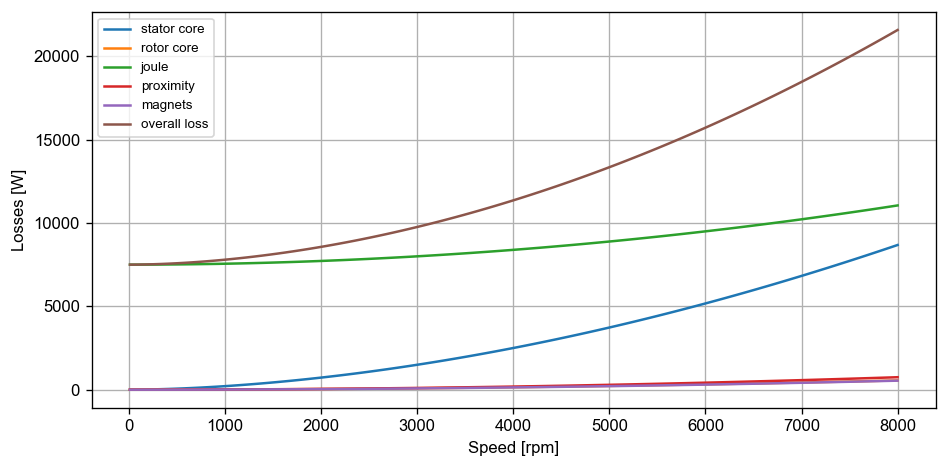

In [23]:
speed_array = np.linspace(10, 8000, 100)
p = machine.get_pole_pair_number()

array_list = [np.array([o.get_loss_scalar(speed / 60 *p) for speed in speed_array])
                for o in out.loss.loss_list if o.name != 'overall']
array_list.append(sum(array_list))

plot_2D(
    [speed_array],
    array_list,
    xlabel="Speed [rpm]",
    ylabel="Losses [W]",
    legend_list=[o.name for o in out.loss.loss_list] + ["overall loss"],
)

## Efficiency map of the machine

The efficiency map of the machine can be constructed by going through several steps.

The next step is to define Simulation containing a *var_simu* attribute with a *VarLoadCurrent*. The *VarLoadCurrent* object needs an *OP_matrix* to define several operating points to carry out multiple simulations. The *OP_matrix* is a matrix with 3 columns representing the following quantities :
1. Rotation speed
2. $I_d$
3. $I_q$

In [25]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent

simu = Simu1(name="test_ElecLUTdq_efficiency_map", machine=machine)

Nspeed = 50

OP_matrix = np.zeros((Nspeed, 3))
OP_matrix[:, 0] = np.linspace(500, 8000, Nspeed)


simu.input = InputCurrent(
    OP=OPdq(),
    Nt_tot=4 * 8,
    Na_tot=200 * 8,
    is_periodicity_a=True,
    is_periodicity_t=True,
)

Pyleecan allows to define a list of DataKeepers. These objects tell the simulation which output to store, and to throw away the others in order to save memory. A we will run many simulations, it is a goood practice to use them.

In [26]:
from pyleecan.Classes.DataKeeper import DataKeeper

datakeeper_list=[
    DataKeeper(
        name = "Torque",
        unit = "N.m", 
        symbol = "T",
        keeper = lambda output: output.elec.Tem_av,
        error_keeper = lambda simu: np.nan
    ),
    DataKeeper(
        name = "Efficiency",
        unit = "", 
        symbol = "eff",
        keeper = lambda output: output.elec.OP.efficiency,
        error_keeper = lambda simu: np.nan
    ),
    DataKeeper(
        name = "current density",
        unit = "A/m^2", 
        symbol = "J",
        keeper = lambda output : output.elec.get_Jrms(),
        error_keeper = lambda simu: np.nan
    ),
    DataKeeper(
        name = "Ud",
        unit = "V", 
        symbol = "Ud",
        keeper = lambda output: output.elec.OP.Ud_ref,
        error_keeper = lambda simu: np.nan
    ),
    DataKeeper(
        name = "Uq",
        unit = "V", 
        symbol = "Uq",
        keeper = lambda output: output.elec.OP.Uq_ref,
        error_keeper = lambda simu: np.nan
    ),
    DataKeeper(
        name = "U0",
        unit = "V", 
        symbol = "U0",
        keeper = lambda output: output.elec.OP.get_U0_UPhi0()["U0"] ,
        error_keeper = lambda simu: np.nan
    ),
    DataKeeper(
        name = "I0",
        unit = "A", 
        symbol = "I0",
        keeper = lambda output: output.elec.OP.get_I0_Phi0()["I0"] ,
        error_keeper = lambda simu: np.nan
    ),
    DataKeeper(
        name = "Phid",
        unit = "Wb", 
        symbol = "Phid",
        keeper = lambda output: output.elec.eec.Phid,
        error_keeper = lambda simu: np.nan
    ),
    DataKeeper(
        name = "Phiq",
        unit = "Wb", 
        symbol = "Phiq",
        keeper = lambda output: output.elec.eec.Phiq,
        error_keeper = lambda simu: np.nan
    ),
]

This DataKeeper list is now used in a VarLoadCurrent object.

In [27]:
OP_matrix = np.zeros((Nspeed, 3))
OP_matrix[:, 0] = np.linspace(500, 6000, Nspeed)
simu.var_simu = VarLoadCurrent(
    datakeeper_list = datakeeper_list
)
simu.var_simu.set_OP_array(OP_matrix, "N0", "Id", "Iq")

The electrical module of the simulation needs to be an ElecLUTdq object to take into account the LUT previously defined.

In [29]:
from pyleecan.Classes.ElecLUTdq import ElecLUTdq
from pyleecan.Classes.PostLUT import PostLUT
from pyleecan.Classes.Loss import Loss

# Definition of a loss model

simu.elec = ElecLUTdq(
        Urms_max=230,  # Maximum rms phase voltage
        Jrms_max=27e6,  # Maximum rms current density in slot
        n_interp=100,  # Number of id values used for interpolation
        n_Id=5,  # Number of Id for LUT calculation
        n_Iq=5,  # Number of Id for LUT calculation
        Id_max=0,  # Maximum Id for LUT calculation
        Iq_min=0,  # Minimum Iq for LUT calculation
        LUT_enforced=None,  # To use previously computed LUT
        is_grid_dq=True,  # True to build a n_Id*n_Iq grid, otherwise calculate n_Id+n_Iq simulations and extrapolate to the dq plane
        Tsta=120,  # Average stator temperature for Electrical calculation [degC]
        type_skin_effect=1,
        LUT_simu=Simu1(
            input=InputCurrent(
                OP=OPdq(),
                Nt_tot=4 *10 *8,
                Na_tot=200 * 8,
                is_periodicity_a=True,
                is_periodicity_t=True,
            ),
            var_simu=VarLoadCurrent(
                postproc_list=[PostLUT(is_save_LUT=True, file_name = "LUT_eff_Toyota_Prius.h5")],
                is_keep_all_output=True,
            ),
            mag=MagFEMM(
                is_periodicity_a=True,
                is_periodicity_t=True,
                nb_worker=4,
                is_get_meshsolution=True,
            ),
            loss = Loss(
                is_get_meshsolution=False,
                Tsta=100,
                model_dict={"stator core": LossModelSteinmetz(group = "stator core"),
                            "rotor core": LossModelSteinmetz(group = "rotor core"),
                            "joule": LossModelWinding(group = "stator winding"),
                            "proximity": LossModelProximity(group = "stator winding"),
                            "magnets": LossModelMagnet(group = "rotor magnets")}
            )
        ),
    )

### Defining a Look up table (LUT)

A look up table is first needed to allow faster computation  during all the simulations. This LUT stores several quantities with respect to the currents $I_d$ and $I_q$.

The LUT can be stored so it is not calculated each time the scipt is run. If this is the first time and the LUT does not exists, it is set to None and will be computed before running other simulations.

In [30]:
from os.path import exists, split
from pyleecan.Functions.Load.load_json import LoadMissingFileError
from pyleecan.definitions import RESULT_DIR

path_to_LUT = r"C:\Users\LAP10\Documents\Loss\LUT_nb.h5"
LUT_file_name = f"LUT_eff_Toyota_Prius.h5"
path_to_LUT = join(RESULT_DIR, LUT_file_name)

try:
    LUT_enforced = load(path_to_LUT)
    simu.elec.LUT_enforced = LUT_enforced
except (FileNotFoundError, LoadMissingFileError):
    print("The LUT could not be loaded, so it will be computed.")
    LUT_enforced = None


Now comes the core of the algorithms. For several values of load rates (defining the required torque), a simlation will be run for every values of speed in the *OP_matrix*. The simulations will be very fast as the magnetic and loss quantities are interpolated from the LUT previously computed.

In [31]:


# Nload simulations will be carried out with load values between 0.1 and 1
Nload = 7
load_vect = np.linspace(0, 1, Nload)

# Several matrixes that will contain relevant data for post_processing are created
OP_matrix_MTPA = np.zeros((Nspeed, Nload, 6))
U_MTPA = np.zeros((Nspeed, Nload, 3))
I_MTPA = np.zeros((Nspeed, Nload, 3))
Phidq_MTPA = np.zeros((Nspeed, Nload, 2))

# An output list is created to contain the Nload outputs that will be computed
out_load = list()


for ii, load_rate in enumerate(load_vect):
    # Re using the LUT computed during the first step
    if ii > 0 and LUT_enforced is None:
            simu.elec.LUT_enforced = load(path_to_LUT)

    simu.elec.load_rate = load_rate

    out = simu.run()

    # Store values in MTPA, the five columns of the OP_matrix_MTPA will be filled
    # First column is rotational speed
    OP_matrix_MTPA[:, ii, 0] = out["N0"].result
    # Second columns is Id
    OP_matrix_MTPA[:, ii, 1] = out["Id"].result
    # Third column is Iq
    OP_matrix_MTPA[:, ii, 2] = out["Iq"].result
    # Fourth column is the average torque
    OP_matrix_MTPA[:, ii, 3] = out["T"].result
    # Fifth column is the efficiency
    OP_matrix_MTPA[:, ii, 4] = out["eff"].result
    # Sixth column is the current density
    OP_matrix_MTPA[:, ii, 5] = out["J"].result
    
    
    # Store the voltages and currents in two dedicated matrixes
    # First column is Ud
    U_MTPA[:, ii, 0] = out["Ud"].result
    # Second column is Uq
    U_MTPA[:, ii, 0] = out["Ud"].result
    # Third column is U0
    U_MTPA[:, ii, 2] = out["U0"].result
    # First column is Id
    I_MTPA[:, ii, 0] = out["Id"].result
    # Second column is Iq
    I_MTPA[:, ii, 1] = out["Iq"].result
    # Third column is I0
    I_MTPA[:, ii, 2] = out["I0"].result
    
    # The fluxes are also stored in their dedicated matrix
    # First column is phid
    Phidq_MTPA[:, ii, 0] = out["Phid"].result
    # second column is phiq
    Phidq_MTPA[:, ii, 1] = out["Phiq"].result
    
    # The output of the current simulation is appended to the list of outputs
    out_load.append(out)

[16:09:07] Starting running simulation test_ElecLUTdq_efficiency_map (machine=Toyota_Prius)
[16:09:14] Computing reference simulation for Variable Load
[16:09:14] Starting Electrical module
[16:09:14] Variable Load Reference Results: T=0 [N.m], eff=0 [], J=0 [A/m^2], Ud=0.005066 [V], Uq=30.96 [V], U0=30.96 [V], I0=0 [A], Phid=0.1478 [Wb], Phiq=-2.419e-05 [Wb], N0=500 [rpm], Id=0 [Arms], Iq=0 [Arms]
[                                                  ]   1%
[16:09:14] Variable Load: Using same LUT for all simulations
[16:09:14] Running simulation 1/50 with N0=500 [rpm], Id=0 [Arms], Iq=0 [Arms]
[16:09:14] Simulation matches reference one: Skipping computation
[16:09:14] Variable Load Results: T=0 [N.m], eff=0 [], J=0 [A/m^2], Ud=0.005066 [V], Uq=30.96 [V], U0=30.96 [V], I0=0 [A], Phid=0.1478 [Wb], Phiq=-2.419e-05 [Wb], N0=500 [rpm], Id=0 [Arms], Iq=0 [Arms]
[=                                                 ]   3%
[16:09:14] Running simulation 2/50 with N0=612.245 [rpm], Id=0 [Arms], Iq=

At the end, the LUT can be stored if it did not exists and has been computed.

## Plots

We need to import plots functions from SciDataTool.

In [32]:
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from SciDataTool.Functions.Plot.plot_3D import plot_3D
#Set the resolution of the figure to make them bigger
plt.rcParams['figure.dpi'] = 150

Now we can simply plot the eficiency map using this code.

c:\users\lap10\documents\scidatatool\SciDataTool\Functions\Plot\plot_3D.py:405: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


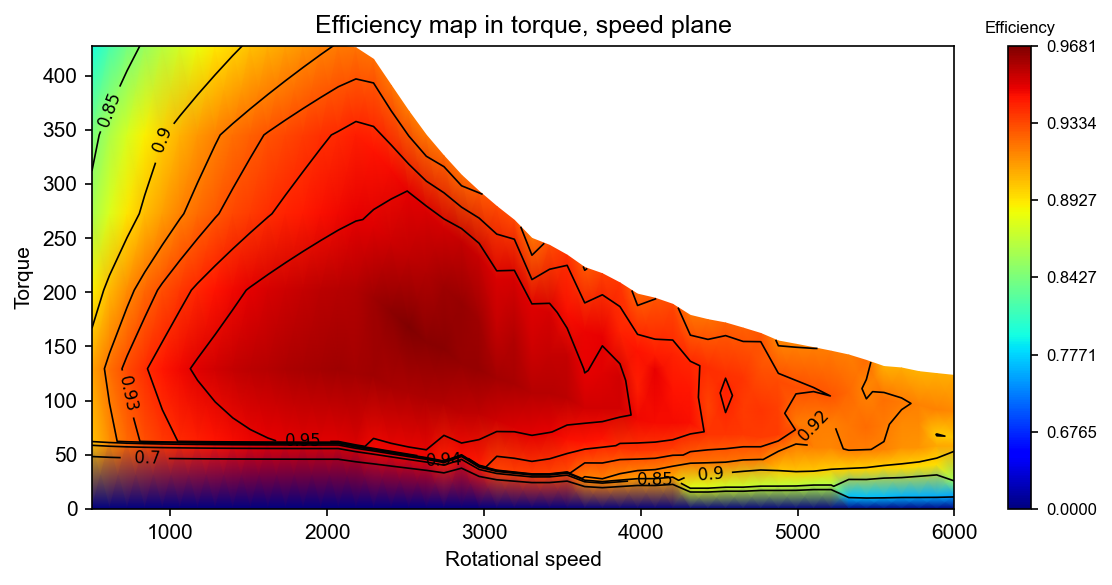

In [33]:
plot_3D(
    Xdata=OP_matrix_MTPA[:, :, 0],  # Rotational speed
    Ydata=OP_matrix_MTPA[:, :, 3],  # Torque
    Zdata=OP_matrix_MTPA[:, :, 4], # Efficiency
    xlabel="Rotational speed",
    ylabel="Torque",
    zlabel="Efficiency",
    title="Efficiency map in torque, speed plane",
    type_plot="pcolormesh",
    is_contour=True,
    levels=[0.7,0.85,0.9,0.92,0.93,0.94,0.95],
    gamma=5
)

Also, the losses can be plotted as a function of $I_d$/$I_q$ thanks to the look up table.

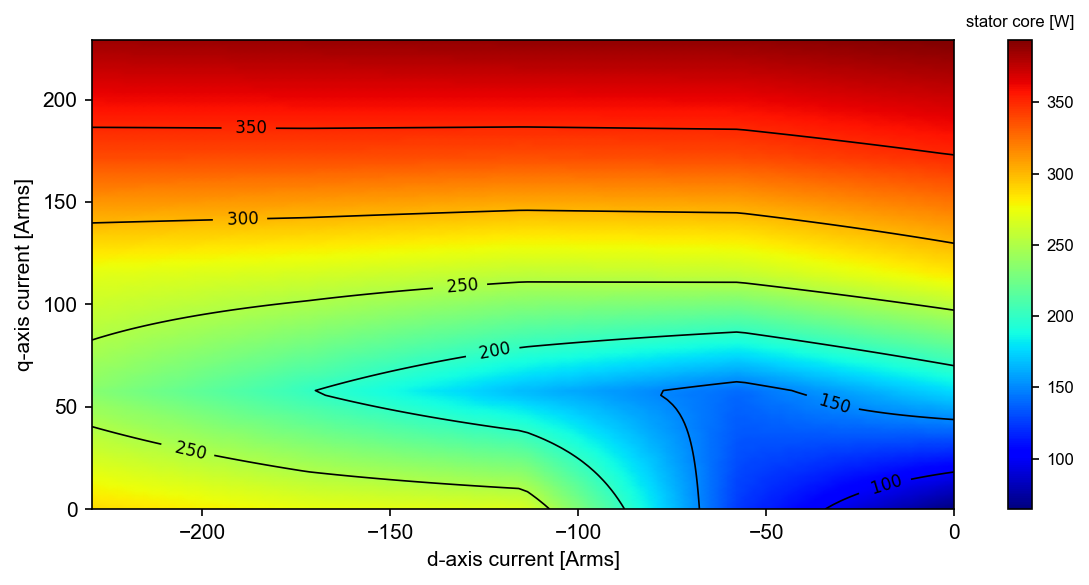

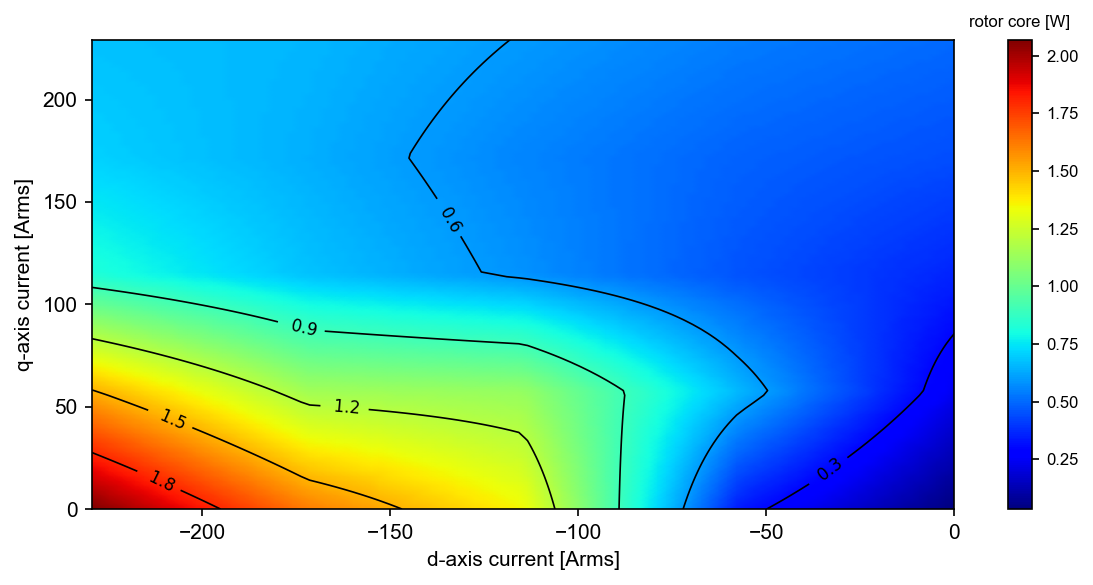

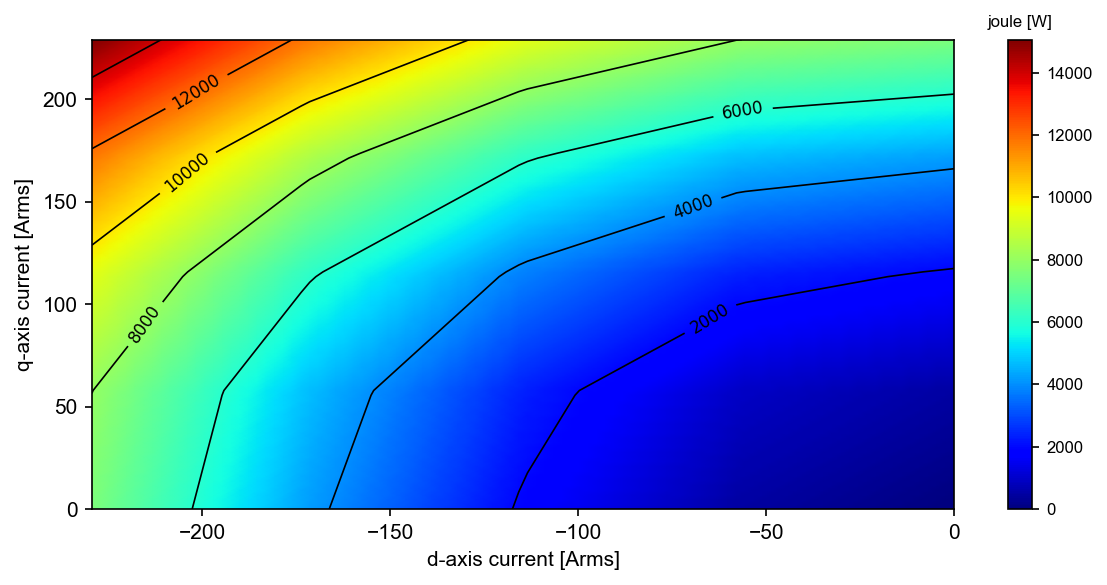

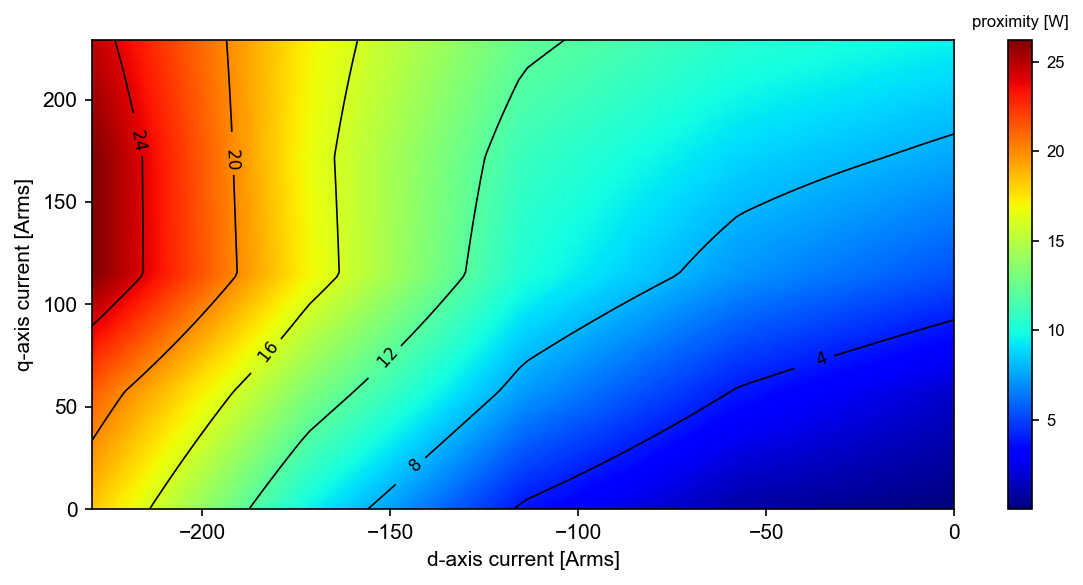

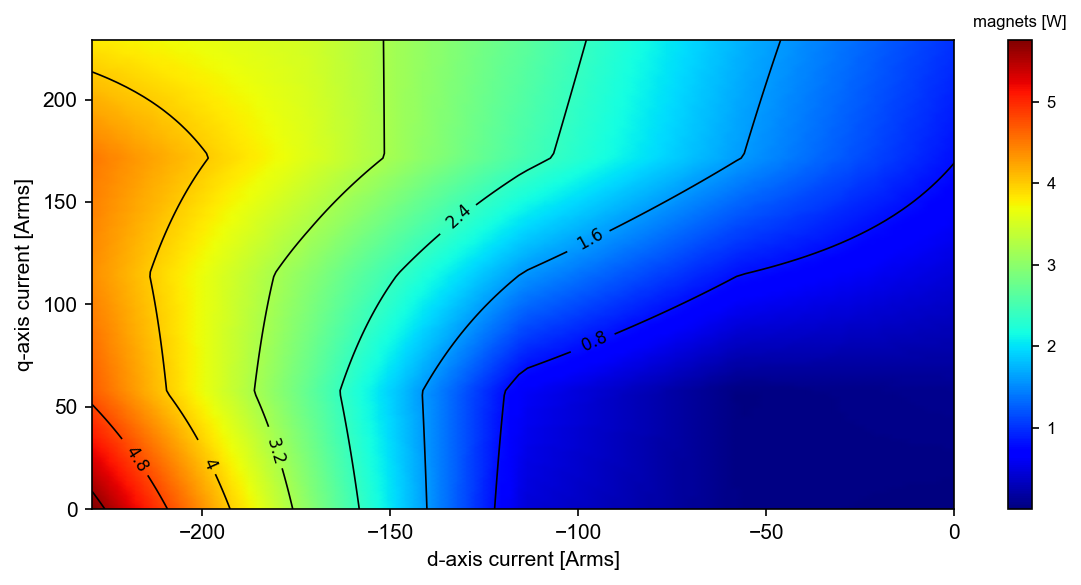

In [35]:
LUT_grid = out.simu.elec.LUT_enforced

# Get Id_min, Id_max, Iq_min, Iq_max from OP_matrix
OP_matrix = LUT_grid.get_OP_array("N0","Id","Iq")
Id_min = OP_matrix[:, 1].min()
Id_max = OP_matrix[:, 1].max()
Iq_min = OP_matrix[:, 2].min()
Iq_max = OP_matrix[:, 2].max()

nd, nq = 100, 100
Id_vect = np.linspace(Id_min, Id_max, nd)
Iq_vect = np.linspace(Iq_min, Iq_max, nq)
Id, Iq = np.meshgrid(Id_vect, Iq_vect)
Id, Iq = Id.ravel(), Iq.ravel()

# Interpolate Phid/Phiq on the refined mesh

Ploss_dqh = LUT_grid.interp_Ploss_dqh(Id, Iq, N0=1200)
dict_map = {
        "Xdata": Id.reshape((nd, nq))[0, :],
        "Ydata": Iq.reshape((nd, nq))[:, 0],
        "xlabel": "d-axis current [Arms]",
        "ylabel": "q-axis current [Arms]",
        "type_plot": "pcolormesh",
        "is_contour": True,
    }
loss_list = ["stator core",
                "rotor core",
                "joule",
                "proximity",
                "magnets"]
for i, loss in enumerate(loss_list):
    plot_3D(
            Zdata=Ploss_dqh[:, i].reshape((nd, nq)),
            zlabel=f"{loss} [W]",
            Xdata= Id.reshape((nd, nq))[0, :],
            Ydata= Iq.reshape((nd, nq))[:, 0],
            xlabel= "d-axis current [Arms]",
            ylabel= "q-axis current [Arms]",
            type_plot= "pcolormesh",
            is_contour= True,
        )

Also, the torque can be plotted as a function of $I_d$/$I_q$.

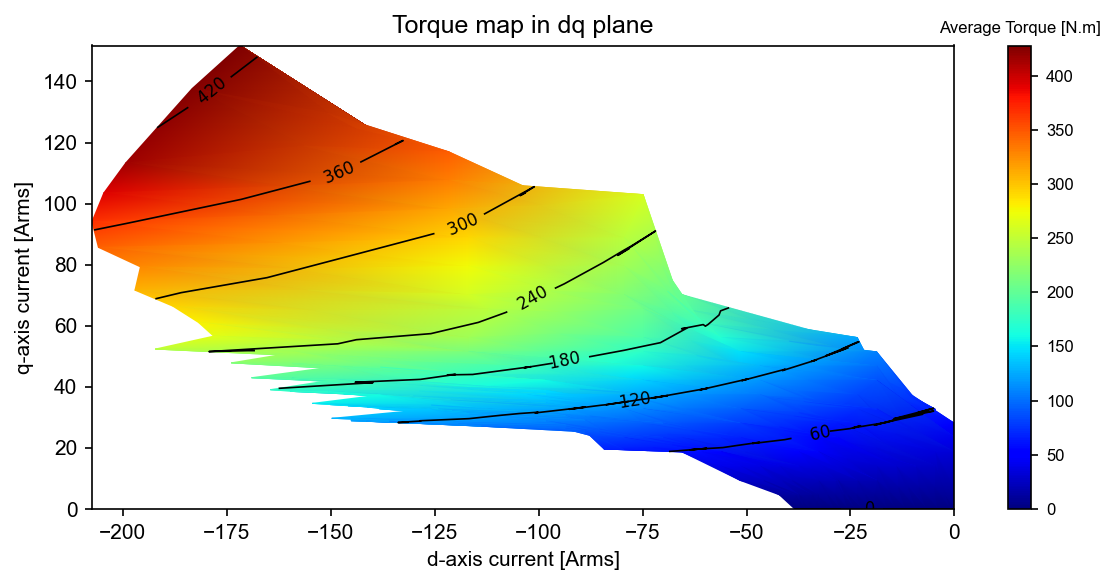

In [36]:
# Plot torque maps
plot_3D(
    Zdata=OP_matrix_MTPA[:, :, 3],
    zlabel="Average Torque [N.m]",
    title="Torque map in dq plane",
    Xdata= I_MTPA[:, :, 0],  # Id
    Ydata= I_MTPA[:, :, 1],  # Iq
    xlabel= "d-axis current [Arms]",
    ylabel= "q-axis current [Arms]",
    type_plot= "pcolormesh",
    is_contour= True,
)

## Loss models comparison

It is possible to compare several loss models in PYLEECAN. To do this, a new simulation will be defined and run as before.


It is possible to compute the Pearson correlation coefficient between the experimental values of loss and the values calculated by PYLEECAN with respect to $B$ for each value of frequency. The results for two different loss models is given in the table below.

|frequency|Bertotti|Steinmetz|
|---|---|---|
|50|0.9966|0.9974|
|60|0.9975|0.9964|
|100|0.9973|0.9978|
|150|0.9979|0.9977|
|200|0.9981|0.9980|
|300|0.9979|0.9977|
|400|0.9987|0.9982|
|600|0.9997|0.9984|
|1000|0.9985|0.9995|
|1500|0.9967|0.9990|
|2000|0.9966|0.9989|
|mean value|0.9978|0.9981|

The Steinmetz model is slightly better in average, but the Bertotti model also gives good results.

In [37]:
simu = Simu1(name="test_loss_models_comparison", machine=machine)


Ic = 230 * np.exp(1j * 140 * np.pi / 180)

simu.input = InputCurrent(
    Nt_tot=40 * 8,
    Na_tot=200 * 8,
    OP=OPdq(N0=1200, Id_ref=Ic.real, Iq_ref=Ic.imag),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    is_get_meshsolution=True,
    is_fast_draw=True,
    is_calc_torque_energy=False,
)


simu.loss = LossFEMM(
    is_get_meshsolution=True,
    Tsta=100,
    model_dict={"stator core Bertotti": LossModelBertotti(group = "stator core"),
                "stator core Steinmetz": LossModelSteinmetz(group = "stator core")}
)

out = simu.run()


[16:11:36] Starting running simulation test_loss_models_comparison (machine=Toyota_Prius)
[16:11:36] Starting Magnetic module
[16:11:38] Solving time steps: 0%
[16:11:38] Solving time steps: 0%
[16:11:39] Solving time steps: 0%
[16:11:39] Solving time steps: 0%
[16:11:43] Solving time steps: 25%
[16:11:44] Solving time steps: 25%
[16:11:44] Solving time steps: 25%
[16:11:45] Solving time steps: 25%
[16:11:49] Solving time steps: 50%
[16:11:49] Solving time steps: 50%
[16:11:49] Solving time steps: 50%
[16:11:50] Solving time steps: 50%
[16:11:53] Solving time steps: 75%
[16:11:54] Solving time steps: 75%
[16:11:55] Solving time steps: 75%
[16:11:56] Solving time steps: 75%
[16:11:57] Solving time step: 100%
[16:11:58] Solving time step: 100%
[16:11:59] Solving time step: 100%
[16:12:00] Solving time step: 100%
[16:12:00] Running LossFEMM module
[16:12:01] End of simulation test_loss_models_comparison


Then, a new output object is created as the difference between the two models defined previously. This object can then be used as any OutLossModel object to visualize the difference.

In [38]:
out.loss.loss_list.append(out.loss.loss_list[0]-out.loss.loss_list[1])
out.loss.loss_list[-1].name = "Difference"

group_names = [
    "stator core",
    "rotor core",
    "rotor magnets"
]
loss = out.loss.loss_list[-1]
loss.get_mesh_solution().plot_contour(
    "freqs=sum",
    label=f"{loss.name} Loss",
    group_names = group_names
)

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

## Comparing several operating points

The losses in several operating points can also be compared by subtracting the loss outputs of several simulations. This is done in the test_loss_dq_Prius.py
